### The model


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
from scipy.spatial import distance_matrix

from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as L
import neurogym as ngym

import matplotlib.pyplot as plt

\begin{align}
    \mathbf{a}(t+\Delta t) = \mathbf{a}(t) + \Delta \mathbf{a} &= \mathbf{a}(t) + \frac{\Delta t}{\tau}[-\mathbf{a}(t) + f(W_{a\rightarrow a} \mathbf{a}(t) + W_{x\rightarrow a}  \mathbf{x}(t) + \mathbf{b}_r)] \\
    &= (1 - \frac{\Delta t}{\tau})\mathbf{a}(t) + \frac{\Delta t}{\tau}f(W_{a\rightarrow a} \mathbf{a}(t) + W_{x\rightarrow a}  \mathbf{x}(t) + \mathbf{b}_r)
\end{align}

In [280]:
class LeakyRNN(nn.Module):
    """ 
     todo: use smarter pytorch tensor initialisation """
    def __init__(self, num_input, num_hidden, dt = 0.05, tau = 100):

        super().__init__()

        # dont need num_out for the layer probably
        self.input_size = num_input
        self.hidden_size = num_hidden

        self.delta_t = dt
        self.tau = tau
        self.alpha = self.delta_t / self.tau
        # self.alpha = 1

        # linear or parameter?
        self.inh = nn.Linear(self.input_size, self.hidden_size)
        self.hh = nn.Linear(self.hidden_size, self.hidden_size)

        self.nonlinearity = nn.LeakyReLU()


    def _init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrent(self, input, hidden):
        # input = x(t)
        # hidden = a(t)
        # hidden_new = a(t + delta_t)

        # W_{a,a} & W_{x,a} are singular with no bias
        hidden_new = self.nonlinearity(self.inh(input) + self.hh(hidden))

        # hidden is a(t), activity of current neuron at time t
        hidden_new = (1 - self.alpha) * hidden + self.alpha * hidden_new

        return hidden_new

    def forward(self, input, hidden=None):

        # on first run initialise hidden
        if hidden is None:
            hidden = self._init_hidden(input.shape).to(input.device)

        # print(f'forward input shape: {input.shape}')
        output = []
        for i in range(len(input)):
            hidden = self.recurrent(input[i], hidden)
            output.append(hidden)
        
        output = torch.stack(output, dim=0)     # seq_len, batch, hidden_size

        return output, hidden


class RNNNet(LightningModule):
    def __init__(self, input_size, hidden_size, output_size, entropy_weights=None, **kwargs):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # leaky layer
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # linear output layer
        self.ho = nn.Linear(hidden_size, output_size)

        self.entropy_weights = entropy_weights     # weight not predicting a spike worse than guessing wrong
        self.lr = 0.001
        self.hidden_states = []

        self.save_hyperparameters()

    def loss(self, output, y):
        loss_func = torch.nn.CrossEntropyLoss(weight=self.entropy_weights)
        return loss_func(output, y)


    def forward(self, input):
        leaky_out, _ = self.rnn(input)
        output = self.ho(leaky_out)

        return output, leaky_out


    def training_step(self, batch, x_idx):
        x, y = batch
        output, _ = self.forward(x)
        output = output.view(-1, self.output_size)
        loss = self.loss(output, y)

        # print(x.shape)
        # print(y.shape)
        # print(y.dtype)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=x.shape[1])

        return loss


    def test_step(self, batch, x_idx):
        # mistake here?
        x, y = batch
        output_raw, hidden_activity = self.forward(x)
        hidden_choice = []

        # for each trial t in the batch
        for t in range(output_raw.shape[1]):
            output_t = output_raw.detach().cpu().numpy()[:, t, :]    # shape (seq_len, dim)
            output_t_choice = [np.argmax(x) for x in output_t]  # index of network choice. shape (seq_len)

            hidden_choice += output_t_choice   # y isn't batched properly so neither is the loss
        
        # 2 losses are important; does the model respond when it should, and is that response correct?

        y_idx = [t for t, l in enumerate(y) if l > 0]   # index of response phases
        choice_idx = [t for t, l in enumerate(hidden_choice) if l > 0]  # index of when model responds

        cue_accuracy = len(choice_idx)/len(y_idx)   # relative amount of guesses that were timed correctly
            # >1 model guesses too frequently, <1 model guesses infrequently, =1 perfect no. guesses
        
        # --------------------------------------------------
        # choice accuracy, even if the choice is early/late
        threshold = 2
        y_idx = np.array(y_idx)
        splits = np.where(np.diff(y_idx) != 1)[0] + 1   # thanks gpt
        y_idx_group = np.split(y_idx, splits)
        correct_count = 0
        print(len(y_idx_group))
        for i in y_idx_group:
            acceptable_guess_idx = []
            for j in i:
                for k in range(-threshold, threshold+1, 1):
                    if j + k >= 0 and j + k < len(hidden_choice):  # prevent -ve indexing
                        acceptable_guess_idx.append(j + k)
            
            correct_target = y[i[0]]
            phase_choice = [hidden_choice[q] for q in set(acceptable_guess_idx) if hidden_choice[q]>0]
            if correct_target in phase_choice:
                correct_count += 1
            
        guess_accuracy = correct_count/len(y_idx_group)

        # error = [0 if c == t else 1 for c, t in zip(hidden_choice, y)]   # final choice binary loss (0 if correct 1 if wrong)
        # self.log('mean_test_loss', np.mean(error), batch_size=x.shape[1])

        self.log('cue_accuracy', cue_accuracy, batch_size=x.shape[1])
        self.log('guess_accuracy', guess_accuracy, batch_size=x.shape[1])

        # stores all netowork activity for analysis
        # todo: fix dtypes to be consistent
        self.hidden_states.append(
            {'output': hidden_choice,
             'target': y,
             'cue_accuracy': cue_accuracy,
             'guess_accuracy': guess_accuracy,
             'hidden': hidden_activity.detach().cpu()
             }
            )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
class NgymWrapper_Iter(IterableDataset):
    """
    Wrapper for converting neurogym dataset into in a pytorch dataset with tensors not numpy arrays. Also handles formatting the trial data for training on multiple tasks simultaneously
    self.dataset() calls a new batch of random trials each time so 2 batches should be never the same, don't worry about validation/test splits just keep iterating

    dataset : dict | list[dict]
        dictionary(s) of neurogym tasks to train model on. Should contain named parameters to pass to ngym.Dataset()
        batch_size is handled at this level so that multiple tasks can be generated proportionally to fill desired batch size
        seq_len is also handled here as the wrapper cannot handle different sequence lengths, np.concatenate fails for different dimension sizes
        see https://neurogym.github.io/neurogym/latest/api/utils/#neurogym.utils.data.Dataset
    
    padding : int
        target input dimension. Used when training/testing the network on task(s) with different dimension to what the network was originally exposed to
        must always be bigger than the largest input vector and should typically be model.input_size


    todo:
        padding:
            pad outputs. needed to test model on unseen tasks before training
            allow variable sequence lengths

    """
    def __init__(self,
                 dataset: dict|list[dict],
                 batch_size: int = 64,
                 batches_per_epoch: int = 1,
                 seq_len: int = 100,
                 padding: int = None
                 ):
        super().__init__()

        if isinstance(dataset, dict):
            self.task_count = 1
            dataset['batch_size'] = batch_size
            dataset['seq_len'] = seq_len
            self.dataset = ngym.Dataset(**dataset)
            
            # self.dataset.env.reset()

        elif isinstance(dataset, list):
            self.task_count = len(dataset)
            # if the number of tasks is not a factor of batch size try to make all task batch sizes as equal as possible, prioritising summing to batch_size
            base_batch_size = batch_size // self.task_count
            additional_batch_count = batch_size % self.task_count
            if additional_batch_count != 0:
                print('Task count not a factor of batch size. Some tasks will be better represented in each batch')
            self.dataset = []
            for t in range(self.task_count):
                _dataset = dataset[t]
                _dataset['seq_len'] = seq_len
                if t<additional_batch_count:
                    _dataset['batch_size'] = base_batch_size+1
                else:
                    _dataset['batch_size'] = base_batch_size

                self.dataset.append(ngym.Dataset(**_dataset))
        
        else:
            assert isinstance(dataset, dict|list), 'dataset not a dictionary, or list of dictionary'

        self.padding = padding
        self.batch_size = batch_size
        self.batches_per_epoch=batches_per_epoch

    def __input_shape(self, dataset):
            env = dataset.env
            return env.observation_space.shape[0]

    def __output_shape(self, dataset):
            env = dataset.env
            return env.action_space.n
    
    @property
    def max_input_shape(self):
        if self.task_count == 1:
            return self.__input_shape(self.dataset)
        else:
            max_input_shape = -1
            for t in range(self.task_count):
                _max_input_shape = self.__input_shape(self.dataset[t])
                if _max_input_shape > max_input_shape:
                    max_input_shape = _max_input_shape
            
            return max_input_shape

    @property
    def max_output_shape(self):
        if self.task_count == 1:
            return self.__output_shape(self.dataset)
        else:
            max_output_shape = -1
            for t in range(self.task_count):
                _max_output_shape = self.__output_shape(self.dataset[t])
                if _max_output_shape > max_output_shape:
                    max_output_shape = _max_output_shape
            
            return max_output_shape


    # i was originally going to train the model on n tasks but i flew too close to the sun and now this
    # is unused :(
    def __pad_inputs(self, inputs):
        if self.padding is None:
            # pad to maximum input dimension
            input_dim_diff = abs(inputs.shape[2] - self.max_input_shape)
            inputs = np.pad(inputs, ((0, 0), (0, 0), (0, input_dim_diff)))
            return inputs
        
        elif self.padding is not None:
            # pad to target input dimension
            assert self.padding >= self.max_input_shape, "target padding must be larger than input shape"
            input_dim_diff = abs(inputs.shape[2] - self.padding)
            inputs = np.pad(inputs, ((0, 0), (0, 0), (0, input_dim_diff)))
            return inputs


    def __get_trials(self):
        if self.task_count == 1:
            inputs, targets = self.dataset()
            inputs = self.__pad_inputs(inputs)
            return inputs, targets
        else:
            # do first trial outside the loop so i dont have to initialise arrays with the right size
            inputs, targets = self.dataset[0]()
            inputs = self.__pad_inputs(inputs)

            for t in range(1, self.task_count):
                _inputs, _targets = self.dataset[t]()
                
                # pad input data so all different stimuli input with the same dimension
                _inputs = self.__pad_inputs(_inputs)

                inputs = np.concatenate([inputs, _inputs], axis=1)
                targets = np.concatenate([targets, _targets], axis=1)
            
            return inputs, targets


    def __iter__(self):
        
        for i in range(self.batches_per_epoch):
            inputs, targets = self.__get_trials()
            # inputs, targets = self.dataset()
            inputs = torch.from_numpy(inputs).type(torch.float)
            targets = torch.from_numpy(targets.flatten()).type(torch.long)
            
            # never seen yield before, returns the object(s) without exiting the function
            yield (inputs, targets)



In [76]:
seed_everything(42)

task_dict0 = {'env': 'PerceptualDecisionMaking-v0',
             'env_kwargs': {'timing': {'fixation': 30,
                            'stimulus': 100,
                            'delay': 0,
                            'decision': 20},
                            'dt': 10
                            }
                }

task_list = [{'env': 'PerceptualDecisionMaking-v0'}, {'env': 'ContextDecisionMaking-v0'}, {'env': 'ProbabilisticReasoning-v0'}, {'env': 'HierarchicalReasoning-v0'}]

trainer_kwargs = {'max_epochs': 250,
                  'logger': TensorBoardLogger('logs/')
                  }
trainer = Trainer(**trainer_kwargs)

train_dataset = NgymWrapper_Iter(task_dict0, batch_size=512, batches_per_epoch=1, seq_len=100)
test_dataset = NgymWrapper_Iter({'env': 'PerceptualDecisionMaking-v0'}, batch_size=64, batches_per_epoch=1)

input_size = train_dataset.max_input_shape if train_dataset.max_input_shape > test_dataset.max_input_shape else test_dataset.max_input_shape
output_size = train_dataset.max_output_shape if train_dataset.max_output_shape > test_dataset.max_output_shape else test_dataset.max_output_shape
hidden_size = 8

print(f'maximum input shape: {train_dataset.max_input_shape}')
print(f'maximum output shape: {test_dataset.max_output_shape}')

entropy_weights = torch.tensor([1.0, 13.0, 13.0], device='cuda')
model = RNNNet(input_size = input_size,
               hidden_size = hidden_size,
               output_size = output_size,
               entropy_weights=entropy_weights,
               dt = 50)
print(model)

trainer.fit(model, train_dataloaders=train_dataset)

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.new_

maximum input shape: 3
maximum output shape: 3
RNNNet(
  (rnn): LeakyRNN(
    (inh): Linear(in_features=3, out_features=8, bias=True)
    (hh): Linear(in_features=8, out_features=8, bias=True)
    (nonlinearity): LeakyReLU(negative_slope=0.01)
  )
  (ho): Linear(in_features=8, out_features=3, bias=True)
  (loss): CrossEntropyLoss()
)
Epoch 249: |          | 1/? [00:00<00:00,  1.71it/s, v_num=0, train_loss=0.844]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: |          | 1/? [00:00<00:00,  1.67it/s, v_num=0, train_loss=0.844]


### Testing
Testing the model with a new, unseen batch of ngym data
For default PerceptualDecisionMaking task, a model that never makes a guess will have an error of 0.04. Maybe use cross entropy since i know it works? or punish the model harshly if it never makes a guess

In [ ]:
# task_list = [{'env': 'PerceptualDecisionMaking-v0'}, {'env': 'ContextDecisionMaking-v0'}, {'env': 'ProbabilisticReasoning-v0'}, {'env': 'HierarchicalReasoning-v0'}] GoNogo
task_dict0 = {'env': 'PerceptualDecisionMaking-v0',
             'env_kwargs': {'timing': {'fixation': 30,
                            'stimulus': 200,
                            'delay': 0,
                            'decision': 20},
                            'dt': 10
                            }
                }

test_dataset = NgymWrapper_Iter(task_dict0, batch_size=1, batches_per_epoch=1)

# model = RNNNet.load_from_checkpoint('./logs/lightning_logs/model-0.1/checkpoints/epoch=49-step=1000.ckpt',
#                                     input_size=41,
#                                     hidden_size=128,
#                                     output_size=5)

trainer_kwargs = {'max_epochs': 1,
                  'logger': TensorBoardLogger('logs/')
                  }

trainer = Trainer(**trainer_kwargs)
trainer.test(model, dataloaders=test_dataset)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 1/? [00:00<00:00, 18.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mean_test_loss         0.4300000071525574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mean_test_loss': 0.4300000071525574}]

In [71]:
print(model.hidden_states[-1].keys())
# model output at t=0
print(model.hidden_states[-1]['output'][0])
# model output at t=seq_len
print(model.hidden_states[-1]['output'])
# ground truth (idk why it changes occasionally must be a bug with neurogym)
print(model.hidden_states[-1]['target'].shape)

print(model.hidden_states[0]['target'])

print(model.hidden_states[0]['target'][11]==model.hidden_states[-1]['output'][11])

# note that the model has 5 outputs but only the first 3 are used for this task

dict_keys(['output', 'target', 'loss', 'hidden'])
0
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)

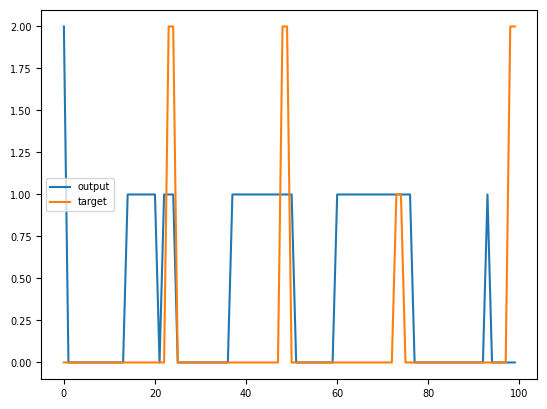

In [88]:
# # print(model.hidden_states[0]['target'])
# target = model.hidden_states[0]['target'].detach().cpu().numpy()
# hidden_choice = []
# hidden_choice = [np.argmax(x) for x in model.hidden_states[-1]['output']]  # index of network choice. shape (seq_len)

# # hidden_choice.append(output_t_choice)   # store choices for all t for analysis
# print(hidden_choice)
# print(target)

# error = [0 if c == t else 1 for c, t in zip(hidden_choice, target)]
# print(error)
# error = np.sum(error)/len(error)
# print(error)

fig, ax = plt.subplots()
ax.plot(range(len(model.hidden_states[-1]['output'])), model.hidden_states[-1]['output'], label='output')
ax.plot(range(len(model.hidden_states[-1]['target'])), model.hidden_states[-1]['target'].detach().cpu(), label='target')
ax.legend()

#### Spatially embedding the network
Spatial RNNs have been shown to converge on brain-like topology
$
\\
L = L_{Task} + \gamma ||W \odot D ||
\\
|| W \odot D|| = \sum_{i=1}^m{\sum_{j=1}^m{|w_{i,j}|\times|d_{i,j}|}}
\\
$

In [277]:
class Spatial_Embedding:
    """
    Handles the spatial stuff 
    """
    def __init__(self,
                 unit_count: int,
                 placement_method: str,
                 placement_params,
                 tensor_mode: bool = True
                 ):
        
        # unit count : size of hidden layer
        # placement_method : how to distribute units throughout the space. 'uniform' or 'normal'
        # tensor_mode : whether to store stuff as tensors. if true uses gpu
        # placement_params (uniform) : x,y boundaries of space. in 2D so that plots can be made easily
        # placement_params (normal): dictionary containing keys ['origin', 'mu'] of length number of clusters
        # origin = [x_coord, y_coord]
        # NUMBER OF GAUSSIAN CLUSTERS MUST BE A FACTOR OF unit_count

        self.unit_count = unit_count
        self.method = getattr(self, placement_method)
        self.placement_params = placement_params
        self.tensor_mode = tensor_mode

        self.method()
    
    def uniform(self):
        x = np.random.uniform(self.placement_params[0, 0], self.placement_params[0, 1], self.unit_count)
        y = np.random.uniform(self.placement_params[1, 0], self.placement_params[1, 1], self.unit_count)

        self.coords = np.stack((x, y), axis=1)
    
    def normal(self):
        assert self.unit_count % len(self.placement_params) == 0, 'number of clusters must be a factor of unit_count'
        x_temp = []
        y_temp = []
        for cluster in self.placement_params:
            x_temp.append(np.random.normal(cluster['origin'][0], scale=cluster['mu'], size=int(self.unit_count/len(self.placement_params))))
            y_temp.append(np.random.normal(cluster['origin'][1], scale=cluster['mu'], size=int(self.unit_count/len(self.placement_params))))

        x = np.concatenate(x_temp)
        y = np.concatenate(y_temp)
        self.coords = np.stack((x, y), axis=1)

    @property
    def distance_matrix(self):
        dist_mat = distance_matrix(self.coords, self.coords)
        if self.tensor_mode is True:
            dist_mat = torch.tensor(dist_mat, device='cuda')
        return dist_mat


In [ ]:
class SERNN(RNNNet):
    # i love python magic
    def __init__(self, input_size, hidden_size, output_size, placement_method, placement_params, entropy_weights = None, gamma = 0.1, **kwargs):
        super().__init__(input_size, hidden_size, output_size, entropy_weights, **kwargs)

        self.spatial = Spatial_Embedding(self.hidden_size, placement_method, placement_params)
        self.gamma = gamma
        self.entropy_weights = entropy_weights


    def loss(self, output, target):
        # new loss function containing both the task cross entropy loss and the distance regularisation
        # from 10.1038/s42256-023-00748-9
        # if this doesnt work quickly i will cry again
        test_loss_method = torch.nn.CrossEntropyLoss(weight=self.entropy_weights)
        w = list(self.rnn.hh.parameters())[0]   # fucked up way of getting the weight matrix
        test_loss = test_loss_method(output, target)
        distance_reg = torch.sum(torch.abs(w) * torch.abs(self.spatial.distance_matrix))
        loss = test_loss + self.gamma*distance_reg

        return loss



In [273]:
gaus_dict = [{'origin': [-1, 0],
              'mu' : 1},
              {'origin': [1, 0],
               'mu': 1}]
test = Spatial_Embedding(unit_count=2, placement_method='uniform')
test1 = Spatial_Embedding(unit_count=8, placement_method='normal', placement_params=gaus_dict)


In [ ]:
trainer_kwargs = {'max_epochs': 250,
                  'logger': TensorBoardLogger('logs/')
                  }

trainer_SERNN = Trainer(**trainer_kwargs)
trainer_RNN = Trainer(**trainer_kwargs)
task_dict_percep = {'env': 'PerceptualDecisionMaking-v0',
             'env_kwargs': {'timing': {'fixation': 10,
                            'stimulus': 100,
                            'delay': 0,
                            'decision': 20},
                            'dt': 10
                            }
                }

task_dict_pulse = {'env': 'PulseDecisionMaking-v0',
             'env_kwargs': {'timing': {'fixation': 10,
                            'stimulus': 100,
                            'delay': 0,
                            'decision': 20},
                            'dt': 10
                            }
                }


train_dataset = NgymWrapper_Iter(task_dict_percep, batch_size=512, batches_per_epoch=5)
input_size = train_dataset.max_input_shape
output_size = train_dataset.max_output_shape
hidden_size = 8
entropy_weights = torch.tensor([1.0, 20.0, 20.0], device='cuda')
print(f'maximum input shape: {train_dataset.max_input_shape}')
print(f'maximum output shape: {test_dataset.max_output_shape}')

model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=entropy_weights, dt=100)
model_RNN = RNNNet(input_size, hidden_size, output_size, entropy_weights=entropy_weights, dt=100)
trainer_SERNN.fit(model_SERNN, train_dataloaders=train_dataset)
trainer_RNN.fit(model_RNN, train_dataloaders=train_dataset)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 104    | train
1 | ho   | Linear           | 27     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
131       Trainable params
0         Non-trainable params
131       Total params
0.001     Total estimate

maximum input shape: 3
maximum output shape: 3
Epoch 0: |          | 2/? [00:01<00:00,  1.37it/s, v_num=87]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
test_dataset = NgymWrapper_Iter(task_dict_pulse, batch_size=100, batches_per_epoch=1)
test_dataset1 = NgymWrapper_Iter(task_dict_pulse, batch_size=100, batches_per_epoch=1)


# model_SERNN = SERNN.load_from_checkpoint('./logs/lightning_logs/model-0.2/checkpoints/epoch=249-step=1250.ckpt')
# model_RNN = RNNNet.load_from_checkpoint('./logs/lightning_logs/model-0.2/checkpoints/epoch=249-step=1250-v1.ckpt')

# i think the model is learning the typical time delay to report choice, not the cue to give the choice. 
# changing the timings or not resetting the dataset causes the model to consistently fire at the wrong time
trainer_SERNN.test(model_SERNN, dataloaders=test_dataset)
trainer_RNN.test(model_RNN, dataloaders=test_dataset1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s][[ 2.9574971e+00 -2.7887337e+00 -2.3228195e+00]
 [ 3.8555782e+00 -2.8529098e+00 -2.9540892e+00]
 [ 4.4948378e+00 -2.6356809e+00 -3.5946379e+00]
 [-1.6903859e-01  4.5357940e-01  8.6869967e-01]
 [-1.6502216e+00  1.0612181e+00  2.0944333e+00]
 [ 3.5983193e+00 -1.8737592e+00 -2.9343340e+00]
 [ 4.6869469e+00 -1.9998513e+00 -4.1719894e+00]
 [ 5.3206520e+00 -1.8324685e+00 -5.0523872e+00]
 [ 5.7633343e+00 -1.5945739e+00 -5.7961593e+00]
 [ 6.0910721e+00 -1.3375275e+00 -6.4468727e+00]
 [ 6.3423367e+00 -1.0832214e+00 -7.0216069e+00]
 [ 6.5398216e+00 -8.4258366e-01 -7.5298243e+00]
 [ 6.6978827e+00 -6.2086529e-01 -7.9782515e+00]
 [ 6.8261032e+00 -4.2011228e-01 -8.3726034e+00]
 [ 6.9311781e+00 -2.4053909e-01 -8.7181730e+00]
 [ 7.0179596e+00 -8.1325814e-02 -9.0199852e+00]
 [ 7.0900774e+00  5.8898937e-02 -9.2827959e+00]
 [ 7.1503115e+00  1.8176703e-01 -9.5110626e+00]
 [ 2.2448995e+00  2.9649112e+00 -4.6485648e+00]
 [ 4.7235227e-01  3.2069397e+00 -

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mean_test_loss         0.2515999972820282
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 1/? [00:02<00:00,  0.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mean_test_loss         0.2842000126838684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mean_test_loss': 0.2842000126838684}]

In [17]:
import importlib
import plotting as p
importlib.reload(p)

<module 'plotting' from 'c:\\Users\\pigwi\\Documents\\Cog-AI\\Coursework\\plotting.py'>

#### Analysing the networks
Both SERNN and RNN networks have been trained on an identical perceptual decision making task
Analyse network activity over a single test

dict_keys(['output', 'target', 'loss', 'hidden'])


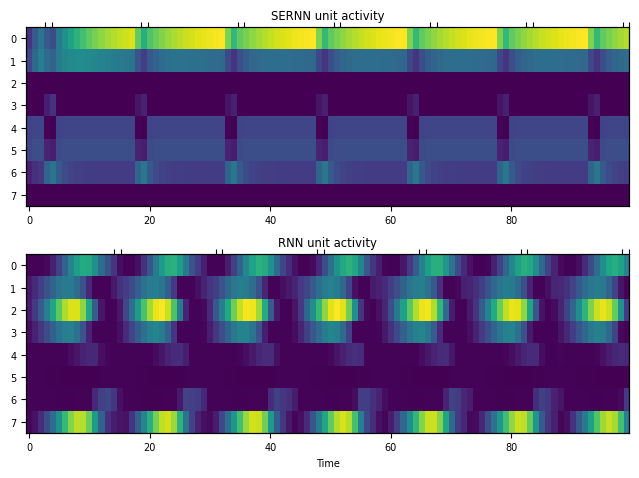

In [386]:
print(model_SERNN.hidden_states[-1].keys())
fig, ax = p.ActivityTrace(model_SERNN, model_RNN)

#### A second task has hit the tower

In [402]:
test_dict1 = {'env': 'PerceptualDecisionMaking-v0',
              'env_kwargs': {'timing': {'fixation': 100,
                            'stimulus': 1000,
                            'delay': 0,
                            'decision': 200},
                            'dt': 100
                            }
                }

test_dataset = NgymWrapper_Iter(test_dict1, batch_size=1000, batches_per_epoch=1)
trainer_SERNN.test(model_SERNN, test_dataset)
test_dataset = NgymWrapper_Iter(test_dict1, batch_size=1000, batches_per_epoch=1)
trainer_RNN.test(model_RNN, test_dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s][[ 2.9574971  -2.7887337  -2.3228195 ]
 [ 2.143918   -2.838736   -1.3456161 ]
 [ 2.0950704  -3.0140061  -1.3374376 ]
 [ 2.6535292  -3.4080834  -2.044358  ]
 [ 3.3792114  -3.673831   -3.095879  ]
 [ 3.4531624  -3.53924    -3.2092216 ]
 [ 2.3867455  -2.581979   -2.1639915 ]
 [ 2.301039   -2.2802227  -2.429147  ]
 [ 1.8374817  -1.5967805  -2.30795   ]
 [ 2.6247396  -1.9581422  -3.3620965 ]
 [ 2.742522   -1.8486009  -3.5628414 ]
 [-1.4344981   1.6709498   0.45058426]
 [-2.4344997   2.4700873   1.1270959 ]
 [ 3.4490564  -0.4765523  -4.505013  ]
 [ 3.8268178  -1.2617531  -4.8243814 ]
 [ 4.700552   -2.337794   -5.6236024 ]
 [ 3.4349594  -1.7955735  -4.029255  ]
 [ 3.4330852  -2.3667717  -3.7066388 ]
 [ 3.6557696  -3.0383937  -3.5973978 ]
 [ 2.8375325  -2.8753085  -2.3616447 ]
 [ 2.7075338  -3.1735926  -1.9957259 ]
 [ 3.0442545  -3.8027933  -2.041933  ]
 [ 2.9261534  -4.0276427  -1.6075017 ]
 [ 2.1360755  -3.5951502  -0.68468887]
 [-2.0853

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 1/? [00:22<00:00,  0.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mean_test_loss         0.2512800097465515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mean_test_loss': 0.2512800097465515}]

# Full training regime

Trains model on many different sequence.
To encourage the model to learn the cue and not the regular time between response phases, train it on many timings at once

In [ ]:
max_epochs = 250
batch_size = 1024
batches_per_epoch = 5

seq_len = 100
dt = 100
stimulus = np.linspace(500, 5000, num=10)
fixation = 200
decision = 200
delay = 0
n_bins = np.array([2, 3, 4, 5, 6])
cue_t = 200
bin_t = 400

input_size = 3
hidden_size = 16
output_size = 3

# punish model more severly for not guessing when it is supposed to to avoid local minima
# how many more no-response targets more than responses in perceptual task
percep_weight = (fixation + stimulus + decision) / decision  
percep_weight_tensor = torch.tensor([1.0, float(np.mean(percep_weight)), float(np.mean(percep_weight))],
                                    device='cuda')

# how many more no-response targets than responses in pulse task
pulse_weight = (2*fixation + decision + (bin_t+cue_t)*(n_bins+1)) / decision
joint_weight = np.concatenate((percep_weight, pulse_weight))

pulse_weight_tensor = torch.tensor([1.0, float(np.mean(pulse_weight)), float(np.mean(pulse_weight))],
                                   device='cuda')

joint_weight_tensor = torch.tensor([1.0, float(np.mean(joint_weight)), float(np.mean(joint_weight))],
                                   device='cuda')



# train RNN and SERNN on each task with many variations of stimulus lenth to force model to learn response cue
perception_task_set = []
pulse_task_set = []
for s in stimulus:
    perception_task_set.append({'env': 'PerceptualDecisionMaking-v0',
                                'env_kwargs': {'timing': {'fixation': fixation,
                                                          'stimulus': s,
                                                          'delay': delay,
                                                          'decision': decision},
                                                'dt': dt
                                            }
                                }
                                )

for n in n_bins:
    # the pulse task timings are broken and don't scale with dt so have to set timings manually
    timings = {'fixation': fixation,
               'decision': decision}
    
    for i in range(n):
        timings[f'cue{i}'] = cue_t
        timings[f'bin{i}'] = bin_t
    
    pulse_temp = {'env': 'PulseDecisionMaking-v0',
                  'env_kwargs': {}
                  }
    pulse_temp['env_kwargs']['timing'] = timings
    pulse_temp['env_kwargs']['dt'] = dt

    pulse_task_set.append(pulse_temp)

joint_task_set = perception_task_set + pulse_task_set

perception_dataset = NgymWrapper_Iter(perception_task_set, batch_size=batch_size, batches_per_epoch=batches_per_epoch)
pulse_dataset = NgymWrapper_Iter(pulse_task_set, batch_size=batch_size, batches_per_epoch=batches_per_epoch)
joint_dataset = NgymWrapper_Iter(joint_task_set, batch_size=batch_size, batches_per_epoch=batches_per_epoch)

trainer_kwargs = {'max_epochs': max_epochs,
                  'log_every_n_steps': 200,
                  }

# # RNN on perception
# model_RNN = RNNNet(input_size, hidden_size, output_size, entropy_weights=percep_weight_tensor, dt=25) #dt=25 so model updates 4 time a second
# trainer = Trainer(logger=TensorBoardLogger('logs/RNN_Perception'), **trainer_kwargs)
# trainer.fit(model_RNN, perception_dataset)

# # RNN on pulse
# model_RNN = RNNNet(input_size, hidden_size, output_size, entropy_weights=pulse_weight_tensor, dt=25)
# trainer = Trainer(logger=TensorBoardLogger('logs/RNN_Pulse'), **trainer_kwargs)
# trainer.fit(model_RNN, pulse_dataset)

# RNN on joint
model_RNN = RNNNet(input_size, hidden_size, output_size, entropy_weights=joint_weight_tensor, dt=25)
trainer = Trainer(logger=TensorBoardLogger('logs/RNN_Joint'), **trainer_kwargs)
trainer.fit(model_RNN, joint_dataset)


# reset datasets because sometimes they might cause problems
perception_dataset = NgymWrapper_Iter(perception_task_set, batch_size=batch_size, batches_per_epoch=batches_per_epoch)
pulse_dataset = NgymWrapper_Iter(pulse_task_set, batch_size=batch_size, batches_per_epoch=batches_per_epoch)
joint_dataset = NgymWrapper_Iter(joint_task_set, batch_size=batch_size, batches_per_epoch=batches_per_epoch)

""" SERNN HAD A DISTANCE MATRIX BUG RETRAINING """
""" UNIFORM SERNN MODELS """
placement_params = np.array([[0, 1], [0, 1]])
# assuming exponential decay, gamma=0.3 causes 0.5 strength regularisation at distance=1
gamma=0.3
# SERNN on perception
model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=percep_weight_tensor,
                    placement_method='uniform', placement_params=placement_params, dt=25, gamma=gamma)
trainer = Trainer(logger=TensorBoardLogger('logs/SERNN_Perception'), **trainer_kwargs)
trainer.fit(model_SERNN, perception_dataset)

# SERNN on pulse
model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=pulse_weight_tensor,
                    placement_method='uniform', placement_params=placement_params, dt=25, gamma=gamma)
trainer = Trainer(logger=TensorBoardLogger('logs/SERNN_Pulse'), **trainer_kwargs)
trainer.fit(model_SERNN, pulse_dataset)

# SERNN on joint
model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=joint_weight_tensor,
                    placement_method='uniform', placement_params=placement_params, dt=25, gamma=gamma)
trainer = Trainer(logger=TensorBoardLogger('logs/SERNN_Joint'), **trainer_kwargs)
trainer.fit(model_SERNN, joint_dataset)

""" GAUSSIAN SERNN MODELS """
# these models have 2 clusters at -1, 1 and should form distinct computational units (hopefully)

gaus_dict = [{'origin': [-1, 0],
              'mu' : 1},
              {'origin': [1, 0],
               'mu': 1}]
# SERNN on perception
model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=percep_weight_tensor,
                    placement_method='normal', placement_params=gaus_dict, dt=25, gamma=gamma)
trainer = Trainer(logger=TensorBoardLogger('logs/SERNNG_Perception'), **trainer_kwargs)
trainer.fit(model_SERNN, perception_dataset)

# SERNN on pulse
model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=pulse_weight_tensor,
                    placement_method='normal', placement_params=gaus_dict, dt=25,
                    gamma=gamma)
trainer = Trainer(logger=TensorBoardLogger('logs/SERNNG_Pulse'), **trainer_kwargs)
trainer.fit(model_SERNN, pulse_dataset)

# SERNN on joint
model_SERNN = SERNN(input_size, hidden_size, output_size, entropy_weights=joint_weight_tensor,
                    placement_method='normal', placement_params=gaus_dict, dt=25,
                    gamma=gamma)
trainer = Trainer(logger=TensorBoardLogger('logs/SERNNG_Joint'), **trainer_kwargs)
trainer.fit(model_SERNN, joint_dataset)

[{'env': 'PulseDecisionMaking-v0', 'env_kwargs': {'timing': {'fixation': 200, 'decision': 200, 'cue0': 200, 'bin0': 400, 'cue1': 200, 'bin1': 400}, 'dt': 100}}, {'env': 'PulseDecisionMaking-v0', 'env_kwargs': {'timing': {'fixation': 200, 'decision': 200, 'cue0': 200, 'bin0': 400, 'cue1': 200, 'bin1': 400, 'cue2': 200, 'bin2': 400}, 'dt': 100}}, {'env': 'PulseDecisionMaking-v0', 'env_kwargs': {'timing': {'fixation': 200, 'decision': 200, 'cue0': 200, 'bin0': 400, 'cue1': 200, 'bin1': 400, 'cue2': 200, 'bin2': 400, 'cue3': 200, 'bin3': 400}, 'dt': 100}}, {'env': 'PulseDecisionMaking-v0', 'env_kwargs': {'timing': {'fixation': 200, 'decision': 200, 'cue0': 200, 'bin0': 400, 'cue1': 200, 'bin1': 400, 'cue2': 200, 'bin2': 400, 'cue3': 200, 'bin3': 400, 'cue4': 200, 'bin4': 400}, 'dt': 100}}, {'env': 'PulseDecisionMaking-v0', 'env_kwargs': {'timing': {'fixation': 200, 'decision': 200, 'cue0': 200, 'bin0': 400, 'cue1': 200, 'bin1': 400, 'cue2': 200, 'bin2': 400, 'cue3': 200, 'bin3': 400, 'cue4

c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-

Task count not a factor of batch size. Some tasks will be better represented in each batch
Task count not a factor of batch size. Some tasks will be better represented in each batch


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 336    | train
1 | ho   | Linear           | 51     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 4: |          | 5/? [00:06<00:00,  0.77it/s, v_num=1, train_loss=5.310]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 5/? [00:06<00:00,  0.77it/s, v_num=1, train_loss=5.310]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 336    | train
1 | ho   | Linear           | 51     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Epoch 4: |          | 5/? [00:07<00:00,  0.70it/s, v_num=1, train_loss=5.720]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 5/? [00:07<00:00,  0.70it/s, v_num=1, train_loss=5.720]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 336    | train
1 | ho   | Linear           | 51     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Epoch 4: |          | 5/? [00:05<00:00,  0.89it/s, v_num=1, train_loss=4.400]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 5/? [00:05<00:00,  0.89it/s, v_num=1, train_loss=4.400]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 336    | train
1 | ho   | Linear           | 51     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Epoch 4: |          | 5/? [00:04<00:00,  1.11it/s, v_num=0, train_loss=19.50]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 5/? [00:04<00:00,  1.11it/s, v_num=0, train_loss=19.50]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 336    | train
1 | ho   | Linear           | 51     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 4: |          | 5/? [00:07<00:00,  0.71it/s, v_num=0, train_loss=15.10]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 5/? [00:07<00:00,  0.70it/s, v_num=0, train_loss=15.10]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | rnn  | LeakyRNN         | 336    | train
1 | ho   | Linear           | 51     | train
2 | loss | CrossEntropyLoss | 0      | train
--------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 4: |          | 5/? [00:05<00:00,  0.88it/s, v_num=0, train_loss=17.10]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 5/? [00:05<00:00,  0.88it/s, v_num=0, train_loss=17.10]


In [165]:
ckpt_path = lambda x: f'logs/{x}/lightning_logs/version_0/checkpoints/epoch=249-step=1250.ckpt'
ckpt_path1 = lambda x: f'logs/{x}/lightning_logs/version_1/checkpoints/epoch=249-step=1250.ckpt'
ckpt_path2 = lambda x: f'logs/{x}/lightning_logs/version_2/checkpoints/epoch=249-step=1250.ckpt'
ckpt_path3 = lambda x: f'logs/{x}/lightning_logs/version_3/checkpoints/epoch=249-step=1250.ckpt'


rnn_joint = RNNNet.load_from_checkpoint(ckpt_path1('RNN_Joint'))
rnn_percep = RNNNet.load_from_checkpoint(ckpt_path('RNN_Perception'))
rnn_pulse = RNNNet.load_from_checkpoint(ckpt_path3('RNN_Pulse'))

sernn_joint = SERNN.load_from_checkpoint(ckpt_path1('SERNN_Joint'), strict=False)
sernn_percep = SERNN.load_from_checkpoint(ckpt_path('SERNN_Perception'), strict=False)
sernn_pulse = SERNN.load_from_checkpoint(ckpt_path3('SERNN_Pulse'), strict=False)

c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\lightning\pytorch\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['loss.weight']


In [184]:
test_percep = {'env': 'PerceptualDecisionMaking-v0',
               'env_kwargs': {'timing': {'fixation': 100,
                                         'stimulus': 1000,
                                         'delay': 0,
                                         'decision': 200},
                              'dt': 100
                              }
               }

test_pulse = {'env': 'PulseDecisionMaking-v0',
              'env_kwargs': {'timing': {'fixation': 200,
                                        'decision': 200,
                                        'cue0': 200, 'bin0': 400,
                                        'cue1': 200, 'bin1': 400,
                                        'cue2': 200, 'bin2': 400},
                             'dt': 100
                             }
                }

pulse_dataset = NgymWrapper_Iter(test_pulse, batch_size=1, batches_per_epoch=100)
percep_dataset = NgymWrapper_Iter(test_percep, batch_size=1, batches_per_epoch=100)

trainer = Trainer(max_epochs=1)

c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-

Test all 6 models on the perceptual task

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]7
Testing DataLoader 0: |          | 1/? [00:00<00:00, 16.02it/s]8
Testing DataLoader 0: |          | 2/? [00:00<00:00, 16.38it/s]8
Testing DataLoader 0: |          | 3/? [00:00<00:00, 17.15it/s]7
Testing DataLoader 0: |          | 4/? [00:00<00:00, 17.38it/s]8
Testing DataLoader 0: |          | 5/? [00:00<00:00, 17.56it/s]8
Testing DataLoader 0: |          | 6/? [00:00<00:00, 17.78it/s]7
Testing DataLoader 0: |          | 7/? [00:00<00:00, 17.82it/s]8
Testing DataLoader 0: |          | 8/? [00:00<00:00, 18.10it/s]8
Testing DataLoader 0: |          | 9/? [00:00<00:00, 18.24it/s]8
Testing DataLoader 0: |          | 10/? [00:00<00:00, 18.43it/s]8
Testing DataLoader 0: |          | 11/? [00:00<00:00, 18.49it/s]8
Testing DataLoader 0: |          | 12/? [00:00<00:00, 18.54it/s]8
Testing DataLoader 0: |          | 13/? [00:00<00:00, 18.67it/s]7
Testing DataLoader 0: |          | 14/? [00:00<00:00, 18.58it/s]8
Testing DataLoader 0: |     

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy           1.046226143836975
     guess_accuracy         0.8751785159111023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]8
Testing DataLoader 0: |          | 1/? [00:00<00:00, 16.33it/s]8
Testing DataLoader 0: |          | 2/? [00:00<00:00, 17.72it/s]8
Testing DataLoader 0: |          | 3/? [00:00<00:00, 17.48it/s]8
Testing DataLoader 0: |          | 4/? [00:00<00:00, 18.01it/s]7
Testing DataLoader 0: |          | 5/? [00:00<00:00, 18.27it/s]8
Testing DataLoader 0: |          | 6/? [00:00<00:00, 18.62it/s]8
Testing DataLoader 0: |          | 7/? [00:00<00:00

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy           0.987500011920929
     guess_accuracy         0.8735713958740234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]8
Testing DataLoader 0: |          | 1/? [00:00<00:00, 19.23it/s]7
Testing DataLoader 0: |          | 2/? [00:00<00:00, 19.79it/s]8
Testing DataLoader 0: |          | 3/? [00:00<00:00, 19.91it/s]8
Testing DataLoader 0: |          | 4/? [00:00<00:00, 20.19it/s]8
Testing DataLoader 0: |          | 5/? [00:00<00:00, 20.17it/s]8
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.55it/s]8
Testing DataLoader 0: |          | 7/? [00:00<00:00

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy                  0.0
     guess_accuracy                 0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]8
Testing DataLoader 0: |          | 1/? [00:00<00:00, 18.02it/s]8
Testing DataLoader 0: |          | 2/? [00:00<00:00, 19.03it/s]7
Testing DataLoader 0: |          | 3/? [00:00<00:00, 19.28it/s]8
Testing DataLoader 0: |          | 4/? [00:00<00:00, 19.44it/s]8
Testing DataLoader 0: |          | 5/? [00:00<00:00, 18.90it/s]7
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.03it/s]8
Testing DataLoader 0: |          | 7/? [00:00<00:00, 18.96it/s]8


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          0.9977618455886841
     guess_accuracy         0.8901785016059875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]8
Testing DataLoader 0: |          | 1/? [00:00<00:00, 17.73it/s]8
Testing DataLoader 0: |          | 2/? [00:00<00:00, 18.89it/s]8
Testing DataLoader 0: |          | 3/? [00:00<00:00, 19.16it/s]8
Testing DataLoader 0: |          | 4/? [00:00<00:00, 19.39it/s]8
Testing DataLoader 0: |          | 5/? [00:00<00:00, 19.32it/s]8
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.51it/s]7
Testing DataLoader 0: |          | 7/? [00:00<00:00

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          1.0120773315429688
     guess_accuracy         0.8771428465843201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]7
Testing DataLoader 0: |          | 1/? [00:00<00:00, 19.52it/s]8
Testing DataLoader 0: |          | 2/? [00:00<00:00, 19.75it/s]8
Testing DataLoader 0: |          | 3/? [00:00<00:00, 20.18it/s]7
Testing DataLoader 0: |          | 4/? [00:00<00:00, 20.02it/s]8
Testing DataLoader 0: |          | 5/? [00:00<00:00, 19.77it/s]8
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.88it/s]7
Testing DataLoader 0: |          | 7/? [00:00<00:00

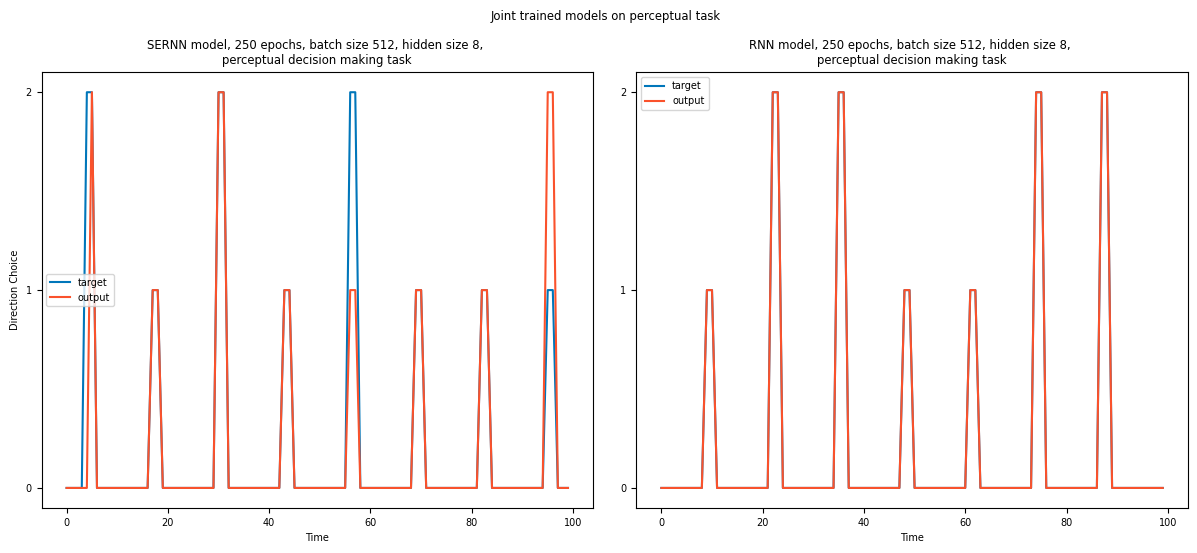

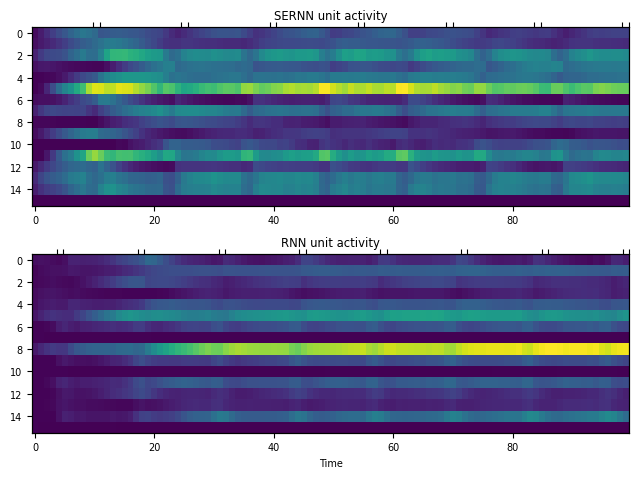

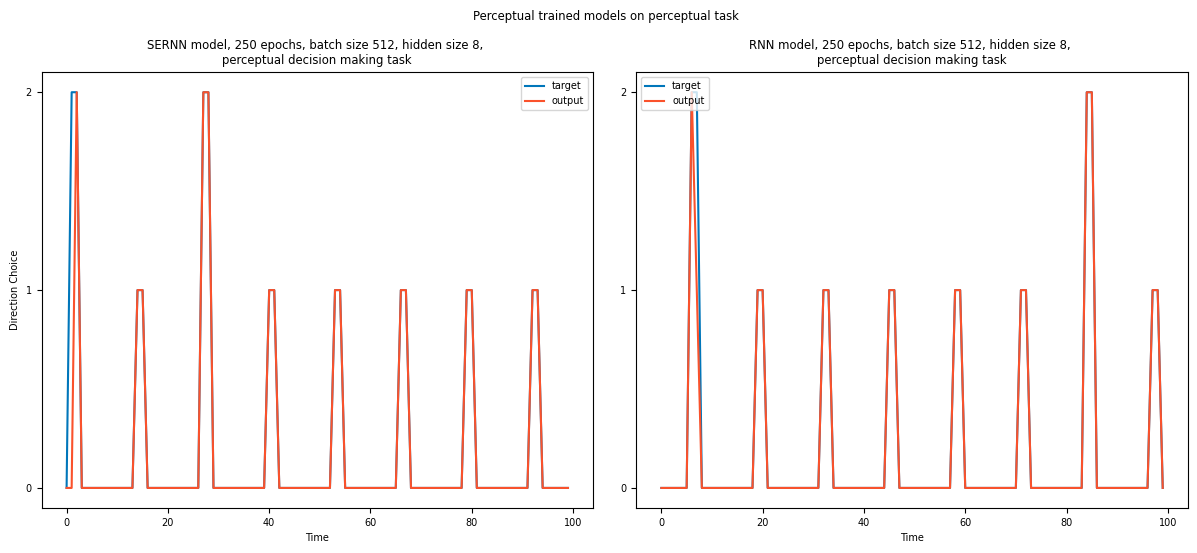

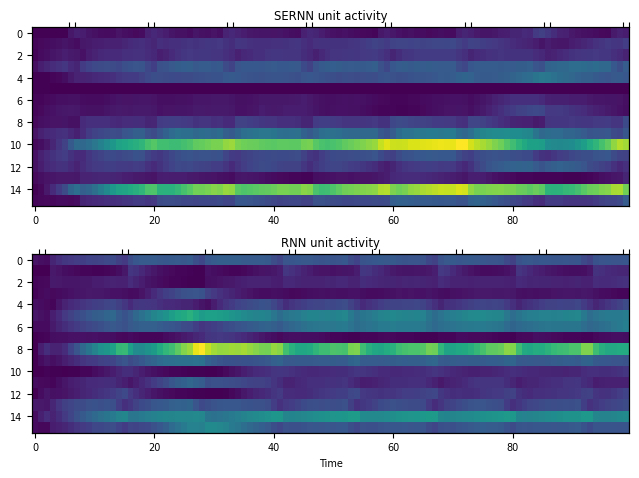

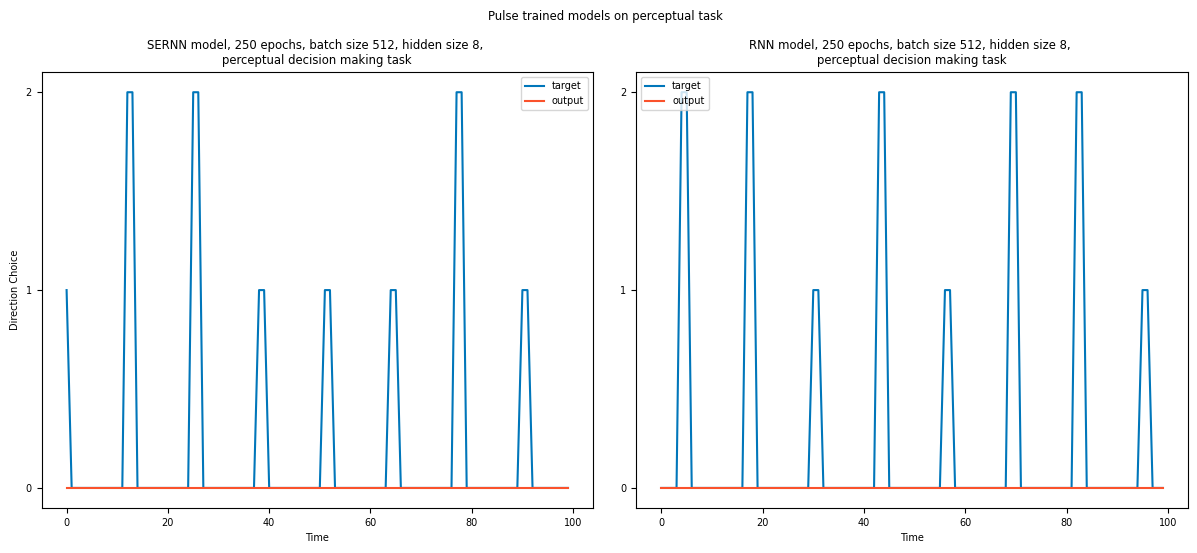

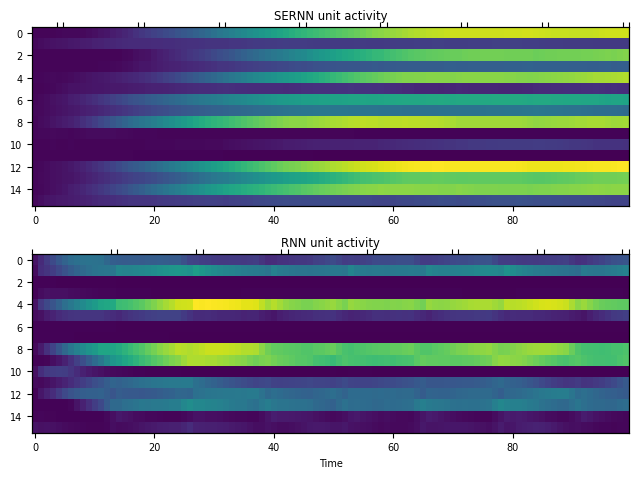

In [185]:
trainer.test(rnn_joint, percep_dataset)
trainer.test(rnn_percep, percep_dataset)
trainer.test(rnn_pulse, percep_dataset)

trainer.test(sernn_joint, percep_dataset)
trainer.test(sernn_percep, percep_dataset)
trainer.test(sernn_pulse, percep_dataset)

fig, ax = p.GuessTrace(sernn_joint, rnn_joint)
fig.suptitle('Joint trained models on perceptual task', y=1.1)
fig, ax = p.ActivityTrace(sernn_joint, rnn_joint)

fig, ax = p.GuessTrace(sernn_percep, rnn_percep)
fig.suptitle('Perceptual trained models on perceptual task', y=1.1)
fig, ax = p.ActivityTrace(sernn_percep, rnn_percep)

fig, ax = p.GuessTrace(sernn_pulse, rnn_pulse)
fig.suptitle('Pulse trained models on perceptual task', y=1.1)
fig, ax = p.ActivityTrace(sernn_pulse, rnn_pulse)


Testing model on pulse task

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]3
Testing DataLoader 0: |          | 1/? [00:00<00:00, 18.36it/s]4
Testing DataLoader 0: |          | 2/? [00:00<00:00, 18.02it/s]3
Testing DataLoader 0: |          | 3/? [00:00<00:00, 18.24it/s]4
Testing DataLoader 0: |          | 4/? [00:00<00:00, 18.70it/s]3
Testing DataLoader 0: |          | 5/? [00:00<00:00, 19.06it/s]4
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.28it/s]4
Testing DataLoader 0: |          | 7/? [00:00<00:00, 19.38it/s]3
Testing DataLoader 0: |          | 8/? [00:00<00:00, 19.48it/s]4
Testing DataLoader 0: |          | 9/? [00:00<00:00, 19.46it/s]3
Testing DataLoader 0: |          | 10/? [00:00<00:00, 19.34it/s]4
Testing DataLoader 0: |          | 11/? [00:00<00:00, 19.24it/s]3
Testing DataLoader 0: |          | 12/? [00:00<00:00, 19.09it/s]4
Testing DataLoader 0: |          | 13/? [00:00<00:00, 18.97it/s]4
Testing DataLoader 0: |          | 14/? [00:00<00:00, 19.01it/s]3
Testing DataLoader 0: |     

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          0.9649999737739563
     guess_accuracy         0.5108332633972168
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]3
Testing DataLoader 0: |          | 1/? [00:00<00:00, 19.82it/s]4
Testing DataLoader 0: |          | 2/? [00:00<00:00, 20.33it/s]3
Testing DataLoader 0: |          | 3/? [00:00<00:00, 20.34it/s]4
Testing DataLoader 0: |          | 4/? [00:00<00:00, 20.50it/s]4
Testing DataLoader 0: |          | 5/? [00:00<00:00, 20.41it/s]3
Testing DataLoader 0: |          | 6/? [00:00<00:00, 20.62it/s]4
Testing DataLoader 0: |          | 7/? [00:00<00:00

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          0.4920833110809326
     guess_accuracy         0.4249999225139618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]3
Testing DataLoader 0: |          | 1/? [00:00<00:00, 17.78it/s]4
Testing DataLoader 0: |          | 2/? [00:00<00:00, 18.69it/s]4
Testing DataLoader 0: |          | 3/? [00:00<00:00, 19.24it/s]3
Testing DataLoader 0: |          | 4/? [00:00<00:00, 19.55it/s]4
Testing DataLoader 0: |          | 5/? [00:00<00:00, 18.81it/s]3
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.07it/s]4
Testing DataLoader 0: |          | 7/? [00:00<00:00

c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.ob to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ob` for environment variables or `env.get_wrapper_attr('ob')` that will search the reminding wrappers.
  logger.warn(
c:\Users\pigwi\miniconda3\envs\Cog-AI\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.gt to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gt` for environment variables or `env.get_wrapp

3
Testing DataLoader 0: |          | 51/? [00:02<00:00, 18.32it/s]4
Testing DataLoader 0: |          | 52/? [00:02<00:00, 18.34it/s]3
Testing DataLoader 0: |          | 53/? [00:02<00:00, 18.37it/s]4
Testing DataLoader 0: |          | 54/? [00:02<00:00, 18.37it/s]3
Testing DataLoader 0: |          | 55/? [00:02<00:00, 18.39it/s]4
Testing DataLoader 0: |          | 56/? [00:03<00:00, 18.39it/s]4
Testing DataLoader 0: |          | 57/? [00:03<00:00, 18.40it/s]3
Testing DataLoader 0: |          | 58/? [00:03<00:00, 18.41it/s]4
Testing DataLoader 0: |          | 59/? [00:03<00:00, 18.43it/s]3
Testing DataLoader 0: |          | 60/? [00:03<00:00, 18.46it/s]4
Testing DataLoader 0: |          | 61/? [00:03<00:00, 18.49it/s]3
Testing DataLoader 0: |          | 62/? [00:03<00:00, 18.52it/s]4
Testing DataLoader 0: |          | 63/? [00:03<00:00, 18.55it/s]4
Testing DataLoader 0: |          | 64/? [00:03<00:00, 18.59it/s]3
Testing DataLoader 0: |          | 65/? [00:03<00:00, 18.61it/s]4
Testing 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          1.2812501192092896
     guess_accuracy         0.7591666579246521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]4
Testing DataLoader 0: |          | 1/? [00:00<00:00, 17.29it/s]3
Testing DataLoader 0: |          | 2/? [00:00<00:00, 18.99it/s]4
Testing DataLoader 0: |          | 3/? [00:00<00:00, 19.22it/s]3
Testing DataLoader 0: |          | 4/? [00:00<00:00, 19.12it/s]4
Testing DataLoader 0: |          | 5/? [00:00<00:00, 19.03it/s]4
Testing DataLoader 0: |          | 6/? [00:00<00:00, 19.10it/s]3
Testing DataLoader 0: |          | 7/? [00:00<00:00

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          0.4062499701976776
     guess_accuracy         0.43166664242744446
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]4
Testing DataLoader 0: |          | 1/? [00:00<00:00, 18.94it/s]3
Testing DataLoader 0: |          | 2/? [00:00<00:00, 19.56it/s]4
Testing DataLoader 0: |          | 3/? [00:00<00:00, 20.15it/s]4
Testing DataLoader 0: |          | 4/? [00:00<00:00, 19.47it/s]3
Testing DataLoader 0: |          | 5/? [00:00<00:00, 19.65it/s]4
Testing DataLoader 0: |          | 6/? [00:00<00:00, 18.80it/s]3
Testing DataLoader 0: |          | 7/? [00:00<00:0

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cue_accuracy          0.17750002443790436
     guess_accuracy         0.10249999910593033
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 0/? [00:00<?, ?it/s]3
Testing DataLoader 0: |          | 1/? [00:00<00:00, 15.54it/s]4
Testing DataLoader 0: |          | 2/? [00:00<00:00, 14.06it/s]3
Testing DataLoader 0: |          | 3/? [00:00<00:00, 14.05it/s]4
Testing DataLoader 0: |          | 4/? [00:00<00:00, 13.45it/s]3
Testing DataLoader 0: |          | 5/? [00:00<00:00, 14.33it/s]4
Testing DataLoader 0: |          | 6/? [00:00<00:00, 15.05it/s]4
Testing DataLoader 0: |          | 7/? [00:00<00:

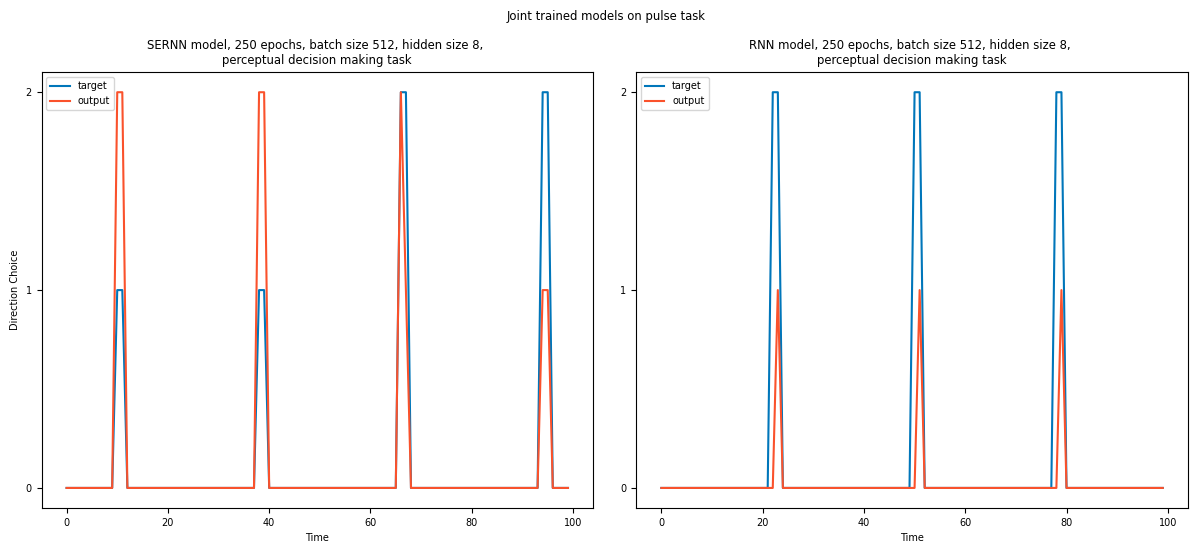

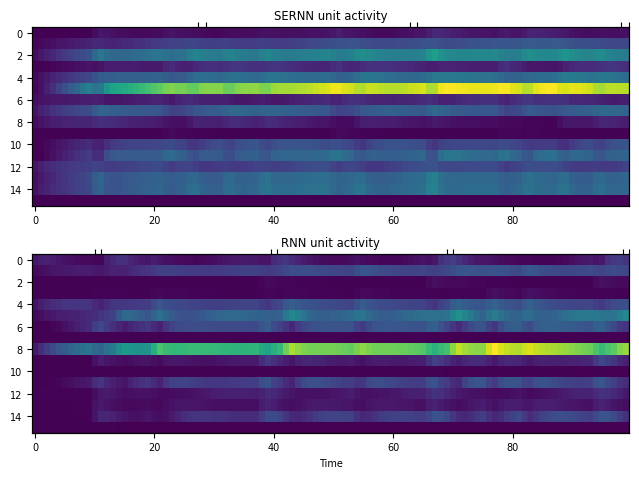

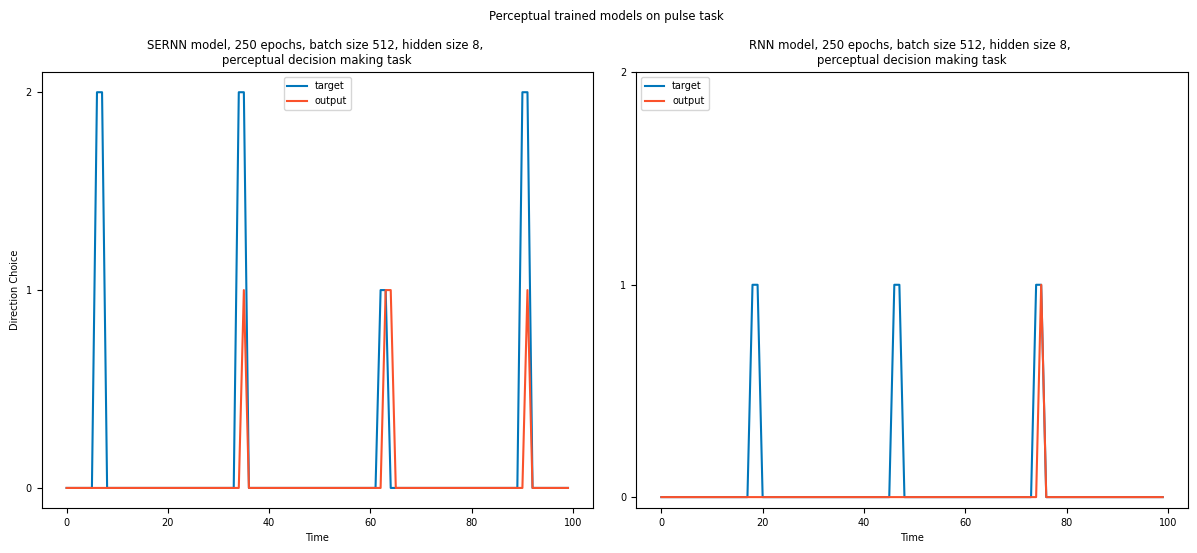

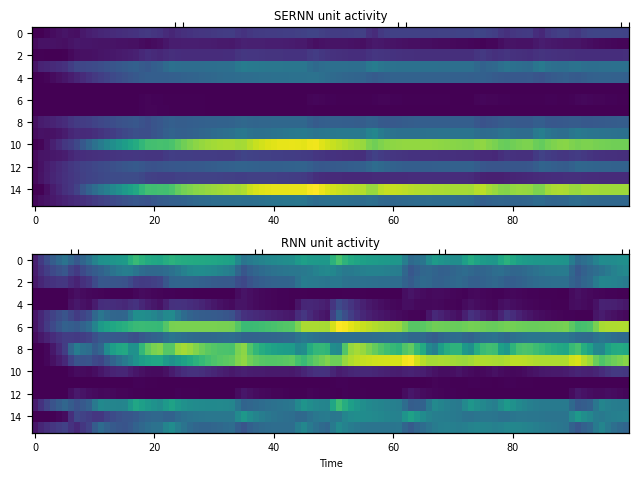

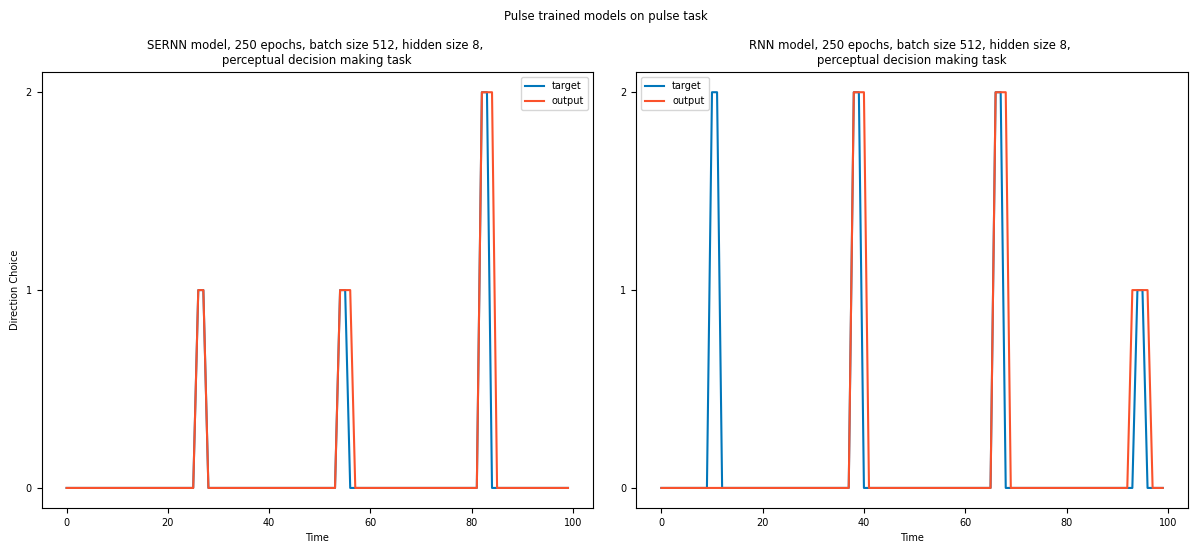

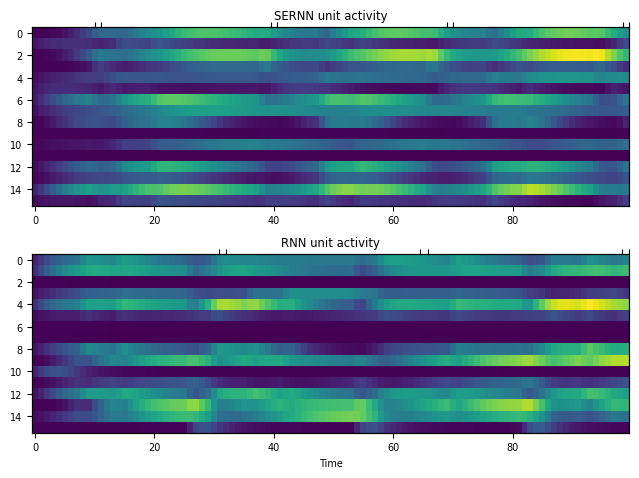

In [186]:
trainer.test(rnn_joint, pulse_dataset)
trainer.test(rnn_percep, pulse_dataset)
trainer.test(rnn_pulse, pulse_dataset)

trainer.test(sernn_joint, pulse_dataset)
trainer.test(sernn_percep, pulse_dataset)
trainer.test(sernn_pulse, pulse_dataset)

fig, ax = p.GuessTrace(sernn_joint, rnn_joint)
fig.suptitle('Joint trained models on pulse task', y=1.1)
fig, ax = p.ActivityTrace(sernn_joint, rnn_joint)

fig, ax = p.GuessTrace(sernn_percep, rnn_percep)
fig.suptitle('Perceptual trained models on pulse task', y=1.1)
fig, ax = p.ActivityTrace(sernn_percep, rnn_percep)

fig, ax = p.GuessTrace(sernn_pulse, rnn_pulse)
fig.suptitle('Pulse trained models on pulse task', y=1.1)
fig, ax = p.ActivityTrace(sernn_pulse, rnn_pulse)

Text(0.5, 0.98, 'Pulse trained SERNN weights')

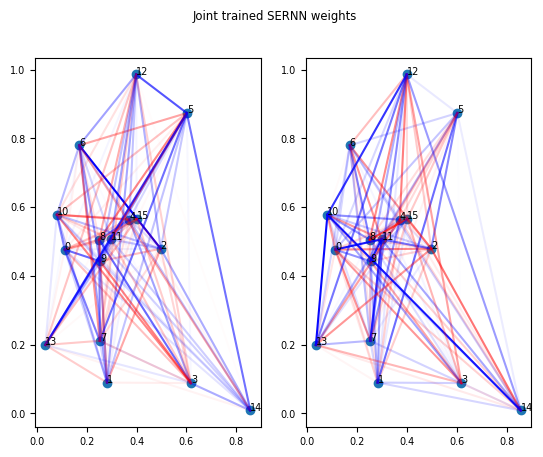

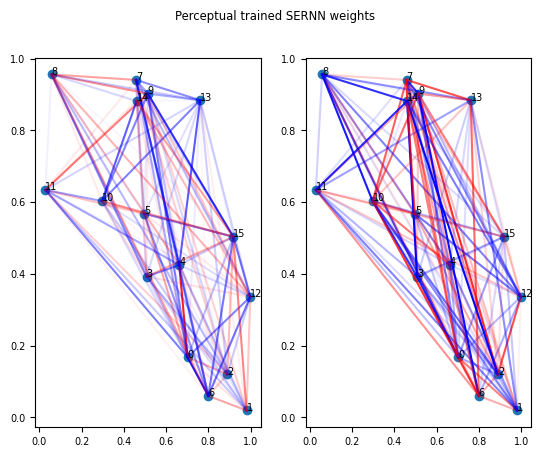

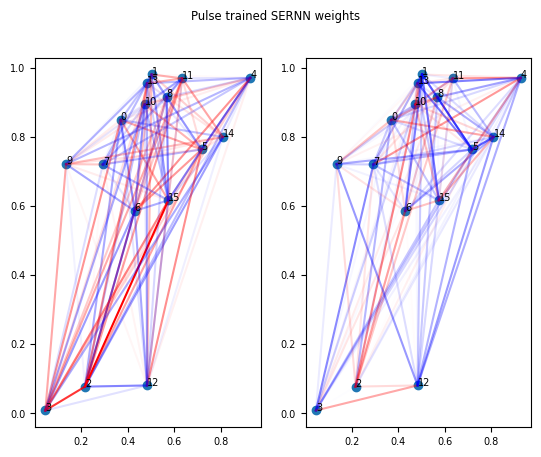

In [183]:
fig, ax = p.MapSERNN(sernn_joint)
fig.suptitle('Joint trained SERNN weights')
fig, ax = p.MapSERNN(sernn_percep)
fig.suptitle('Perceptual trained SERNN weights')
fig, ax = p.MapSERNN(sernn_pulse)
fig.suptitle('Pulse trained SERNN weights')

In [79]:
np.abs(1.0)

np.float64(1.0)

In [90]:
import importlib
import plotting as p
importlib.reload(p)

<module 'plotting' from 'c:\\Users\\pigwi\\Documents\\Cog-AI\\Coursework\\plotting.py'>

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |          | 1/? [00:00<00:00, 19.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mean_test_loss        0.029999999329447746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: |          | 1/? [00:00<00:00, 17.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     mean_test_loss         0.05999999865889549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


(<Figure size 1200x480 with 2 Axes>,
 array([<Axes: title={'center': 'SERNN model, 250 epochs, batch size 512, hidden size 8, \nperceptual decision making task'}, xlabel='Time', ylabel='Direction Choice'>,
        <Axes: title={'center': 'RNN model, 250 epochs, batch size 512, hidden size 8, \nperceptual decision making task'}, xlabel='Time'>],
       dtype=object))

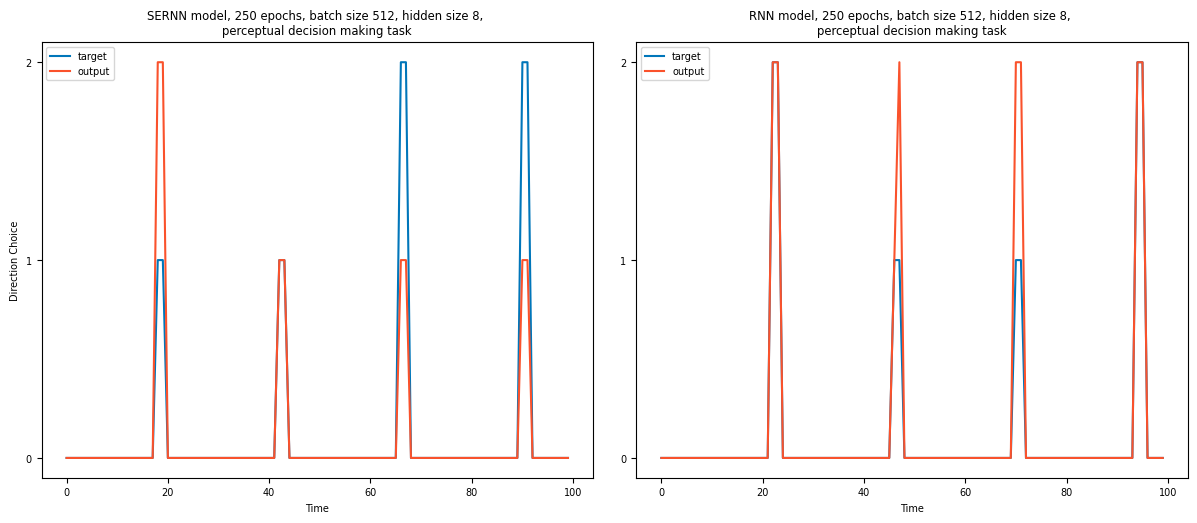

In [124]:
task_dict_percep = {'env': 'PerceptualDecisionMaking-v0',
             'env_kwargs': {'timing': {'fixation': 100,
                            'stimulus': 1000,
                            'delay': 0,
                            'decision': 200},
                            'dt': 100
                            }
                }

task_dict_pulse = {'env': 'PulseDecisionMaking-v0',
             'env_kwargs': {'timing': {'fixation': 1000,
                            'decision': 200},
                            'dt': 100
                            }
                }

pulse_dataset = NgymWrapper_Iter(task_dict_pulse, batch_size=1)
percep_dataset = NgymWrapper_Iter(task_dict_percep, batch_size=1)


rnn_pulse = RNNNet.load_from_checkpoint('logs/RNN_Pulse/lightning_logs/version_2/checkpoints/epoch=249-step=1250.ckpt')
rnn_pulse_old = RNNNet.load_from_checkpoint(ckpt_path1('RNN_Pulse'))
trainer = Trainer(max_epochs=5)
trainer.test(rnn_pulse, pulse_dataset)
trainer.test(rnn_pulse_old, pulse_dataset)

p.GuessTrace(rnn_pulse, rnn_pulse_old)